In [710]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from numpy import random
from sklearn.cluster import KMeans
from sklearn.tree import plot_tree

In [683]:
#reading in datasets
pickle_in = open("subscribers","rb")
subs = pickle.load(pickle_in)
pickle_in = open("engagement","rb")
eng = pickle.load(pickle_in)
pickle_in = open("customer_service_reps","rb")
csr = pickle.load(pickle_in)

In [658]:
ads=pd.read_csv('adspend.csv')

## Data Prep

In [659]:
#change adspend data layout; divide june cost by 30 since only one day was recorded

ads=ads.set_index('date')
ads=ads.stack().reset_index().rename(columns={'date':'months','level_1':'channel',0:'cost'})
ads.cost=ads.cost.str.replace(',','').astype(float)
ads['months']=pd.to_datetime(ads['months'])
ads['months']=ads.months.dt.month
ads['cost']=np.where(ads.months==6,ads.cost/30,ads.cost)

In [660]:
#convert dates to month for merging

subs['channel']=subs.attribution_technical
subs['months']=subs.account_creation_date.dt.month

# CAC

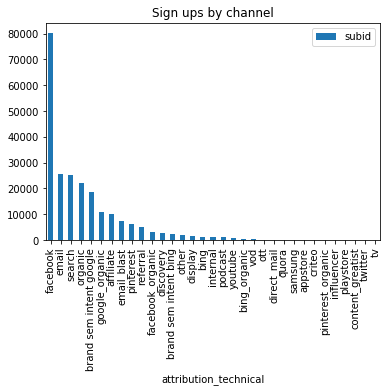

In [662]:
#plot channel by number of sign ups
subs.groupby('attribution_technical')['subid'].nunique().reset_index()\
.sort_values(by='subid',ascending=False)\
.plot.bar(x='attribution_technical',y='subid',title='Sign ups by channel')

In [663]:
#percentage of sign ups from each channel
df=subs.groupby('attribution_technical')['subid'].nunique().reset_index()\
.sort_values(by='subid',ascending=False)
df['perc']=df.subid/df['subid'].sum()
df

,attribution_technical,subid,perc
13,facebook,80251,0.352553
11,email,25690,0.112860
28,search,25306,0.111173
18,organic,22013,0.096706
5,brand sem intent google,18524,0.081378
15,google_organic,10691,0.046967
0,affiliate,9894,0.043466
12,email_blast,7277,0.031969
21,pinterest,6065,0.026644
26,referral,5170,0.022712


In [664]:
#return dataset with only users who went through adspend channels 

tech_att=pd.merge(subs,ads,on=['months','channel'])


In [665]:
#only return customers who are new and not in June

tech_att=tech_att[tech_att.retarget_TF==False]

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

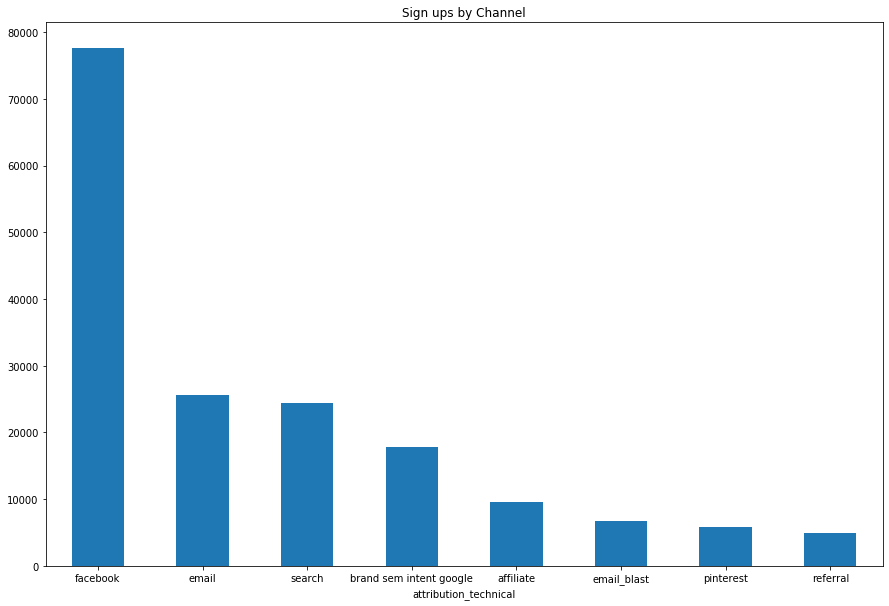

In [666]:
#plot channel by number of sign ups
tech_att.groupby('attribution_technical')['subid'].nunique().reset_index()\
.sort_values(by='subid',ascending=False)\
.plot.bar(x='attribution_technical',y='subid',title='Sign ups by Channel',figsize=(15,10),legend=None)
plt.xticks(rotation = 0)



In [667]:
#percentage of sign ups from each channel
df=tech_att.groupby('attribution_technical')['subid'].nunique().reset_index()\
.sort_values(by='subid',ascending=False)
df['perc']=df.subid/df['subid'].sum()
df

,attribution_technical,subid,perc
4,facebook,77567,0.449307
2,email,25580,0.148172
7,search,24390,0.141279
1,brand sem intent google,17864,0.103477
0,affiliate,9563,0.055394
3,email_blast,6810,0.039447
5,pinterest,5899,0.034170
6,referral,4964,0.028754


In [668]:
df1=tech_att.groupby(['months','channel']).agg(
    signups=('subid','count'),
    spend=('cost','mean')).reset_index()

df1['cac_channel']=df1.spend/df1.signups
df1

,months,channel,signups,spend,cac_channel
0,1,affiliate,1026,14300.0,13.937622
1,1,brand sem intent google,2535,22700.0,8.954635
2,1,email,2362,75500.0,31.964437
3,1,email_blast,30,300.0,10.000000
4,1,facebook,6036,49000.0,8.117959
...,...,...,...,...,...
75,12,email_blast,403,3500.0,8.684864
76,12,facebook,8935,51400.0,5.752658
77,12,pinterest,835,7200.0,8.622754
78,12,referral,633,8000.0,12.638231


In [679]:
df2=df1.groupby('months').agg(
total_spend=('spend','sum'),
total_signups=('signups','sum')).reset_index()

df2['cac_month']=df2.total_spend/df2.total_signups
df2

# Clustering

In [717]:
#reading in datasets
pickle_in = open("subscribers","rb")
subs = pickle.load(pickle_in)
pickle_in = open("engagement","rb")
eng = pickle.load(pickle_in)
pickle_in = open("customer_service_reps","rb")
csr = pickle.load(pickle_in)

In [718]:
#return engagement data from trial period only

eng0=eng[eng.payment_period==0]

In [721]:
#create features to roll up to subscriber level

df_eng0=eng0.groupby(['subid']).agg(
    days=('date','nunique'),
    appopens=('app_opens','sum'),
    vids_complete=('num_videos_completed','sum'),
    num_vids_30sec=('num_videos_more_than_30_seconds','sum'),
    num_vids_rated=('num_videos_rated','sum'),
    series_starts=('num_series_started','sum'),
    max_date=('date','max'),
    min_date=('date','min'),
    mssgs=('cust_service_mssgs','sum')
).reset_index()

df_eng0['duration']=(df_eng0.max_date-df_eng0.min_date).dt.days+1
df_eng0['opensperday']=df_eng0.appopens/df_eng0.days
df_eng0['perc_complete'] = df_eng0.apply(lambda x: 0 if x['num_vids_30sec']==0 else x['vids_complete']/x['num_vids_30sec'], axis=1)
df_eng0['perc_rate'] = df_eng0.apply(lambda x: 0 if x['vids_complete']==0 else x['num_vids_rated']/x['vids_complete'], axis=1)
df_eng0['seriesperopen'] = df_eng0.apply(lambda x: 0 if x['appopens']==0 else x['series_starts']/x['appopens'], axis=1)
df_eng0['vidscompperday']=df_eng0.vids_complete/df_eng0.days
df_eng0['vidswatchperday']=df_eng0.num_vids_30sec/df_eng0.days
df_eng0['seriesperday']=df_eng0.series_starts/df_eng0.days
df_eng0['mssgsperday']=df_eng0.mssgs/df_eng0.days
df_eng0['daysperduration']=df_eng0.days/df_eng0.duration

In [847]:
df_se0=pd.merge(subs,df_eng0,on='subid')

In [848]:
df_se0=df_se0[(df_se0.retarget_TF==False)]

In [849]:
# based on engagement data
kmdf=df_se0[['appopens','vids_complete','num_vids_30sec','series_starts','mssgs']]

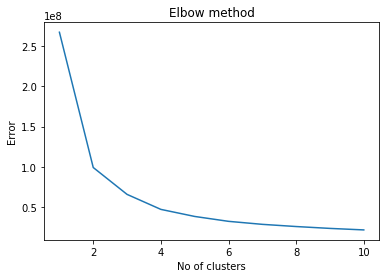

In [850]:
Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(kmdf)
    kmeans.fit(kmdf)
    Error.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

In [851]:
km = KMeans(n_clusters=4)
y_kmeans=km.fit_predict(kmdf)

In [853]:
pd.DataFrame(km.cluster_centers_, columns = kmdf.columns).sort_values(by='appopens')

,appopens,vids_complete,num_vids_30sec,series_starts,mssgs
2,4.803319,6.453395,17.232909,0.809587,2.434218
0,18.330798,26.114018,50.370566,6.073602,4.923056
1,27.534439,62.692805,72.587569,12.650141,7.672577
3,93.716990,63.738064,73.686153,13.114895,8.638647


# Churn Modelling

In [375]:
pickle_in = open("subscribers","rb")
subs = pickle.load(pickle_in)
pickle_in = open("engagement","rb")
eng = pickle.load(pickle_in)
pickle_in = open("customer_service_reps","rb")
csr = pickle.load(pickle_in)

In [376]:
#return with only subscribers with engagement data
csr=csr[csr.subid.isin(eng.subid)]

In [377]:
#find max payment period for each subscriber
df=csr.groupby('subid')['payment_period'].max().reset_index(name='max_period')
df2=pd.merge(df,csr,on=['subid'])

#get subscribers that aren't current subscribers and in period 1 currently
df2=df2[~((df2.max_period==1) & (df2.current_sub_TF==True))]

In [380]:
csr=csr[csr.subid.isin(df2.subid)]

In [381]:
#remapping NA in renew column
csr['renew']=np.where(csr.next_payment.isna()==False,True,False)

#return only info from 1st period in csr
csr=csr[csr.payment_period==1]

#return only csr info for users who didn't ask for refund after trial
csr=csr[csr.subid.isin(subs[subs.refund_after_trial_TF==False].subid)]

In [384]:
#return engagement data for non-NA and users in csr and data not from trial period
eng = eng[(eng['app_opens'].notna()) & (eng.subid.isin(csr.subid)) & (eng.payment_period!=0)]

In [392]:
#create features to roll up to subscriber level

df=eng.groupby(['subid']).agg(
    days=('date','nunique'),
    appopens=('app_opens','sum'),
    vids_complete=('num_videos_completed','sum'),
    num_vids_30sec=('num_videos_more_than_30_seconds','sum'),
    num_vids_rated=('num_videos_rated','sum'),
    series_starts=('num_series_started','sum'),
    max_date=('date','max'),
    min_date=('date','min'),
    mssgs=('cust_service_mssgs','sum')
).reset_index()

df['duration']=(df.max_date-df.min_date).dt.days+1
df['opensperday']=df.appopens/df.days
df['perc_complete'] = df.apply(lambda x: 0 if x['num_vids_30sec']==0 else x['vids_complete']/x['num_vids_30sec'], axis=1)
df['perc_rate'] = df.apply(lambda x: 0 if x['vids_complete']==0 else x['num_vids_rated']/x['vids_complete'], axis=1)
df['seriesperopen'] = df.apply(lambda x: 0 if x['appopens']==0 else x['series_starts']/x['appopens'], axis=1)
df['vidscompperday']=df.vids_complete/df.days
df['vidswatchperday']=df.num_vids_30sec/df.days
df['seriesperday']=df.series_starts/df.days
df['opensperduration']=df.appopens/df.duration
df['vidscompperduration']=df.vids_complete/df.duration
df['seriesperduration']=df.series_starts/df.duration
df['mssgsperday']=df.mssgs/df.days
df['mssgsperduration']=df.mssgs/df.duration
df['perc_mssgs_start']=df.apply(lambda x: 0 if x['num_vids_30sec']==0 else x['mssgs']/x['num_vids_30sec'], axis=1)
df['perc_mssgs_comp'] = df.apply(lambda x: 0 if x['vids_complete']==0 else x['mssgs']/x['vids_complete'], axis=1)
df['mssgsperopen'] = df.apply(lambda x: 0 if x['appopens']==0 else x['mssgs']/x['appopens'], axis=1)
df['daysperduration']=df.days/df.duration
df['weighted_vids']=df.vids_complete*df.daysperduration
df['weighted_starts']=df.num_vids_30sec*df.daysperduration
df['weighted_mssgs']=df.mssgs*df.daysperduration

In [394]:
df_se=pd.merge(subs,df,on=['subid'])
df_mod=pd.merge(df_se,csr,on=['subid'])

In [395]:
#add column with difference in prices
df_mod['price_diff']=df_mod.monthly_price-df_mod.discount_price
df_mod['male_TF']=df_mod['male_TF'].astype(int)

In [398]:
#get dataset for training/testing

X=df_mod[['opensperday', 'perc_complete', 'perc_rate',
       'seriesperopen', 'vidscompperday', 'vidswatchperday', 'seriesperday',
       'opensperduration', 'vidscompperduration', 'seriesperduration',
       'mssgsperday', 'mssgsperduration', 'perc_mssgs_start',
       'perc_mssgs_comp', 'mssgsperopen', 'weighted_vids',
       'weighted_starts', 'weighted_mssgs']]

In [400]:
#remove correlated columns
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
X=X.drop(X[to_drop], axis=1)

In [401]:
#split/train; reassign 1 to mean churn and 0 to mean renew
y = df_mod['renew']
y= y.replace(False,0)
y=y.replace(True,1)
y=abs(y-1)
 
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [164]:
#import necessary packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [341]:
X_train_lr=X_train.copy()
X_test_lr=X_test.copy()

In [342]:
scaler = StandardScaler()

X_train_lr= scaler.fit_transform(X_train_lr)
X_test_lr = scaler.transform(X_test_lr)

In [343]:
#Logistic Regression 

clf = LogisticRegression(random_state=0)

param_test = {
        'C': [0.001,0.01,0.1,1,10,100]
    }

gsearch = GridSearchCV(clf, param_grid = param_test, scoring='roc_auc')
gsearch.fit(X_train_lr,y_train)

print(gsearch.best_params_)
print('best score is:',str(gsearch.best_score_))

/Users/raywu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/raywu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/raywu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/raywu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/raywu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWa

{'C': 0.1}
best score is: 0.5834104959150493


/Users/raywu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/raywu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/raywu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/raywu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/raywu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs

In [344]:
clf = LogisticRegression(C=0.1).fit(X_train_lr, y_train)
y_pred = clf.predict(X_test_lr)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
fpr, tpr, threshold = metrics.roc_curve(y_test, clf.predict_proba(X_test_lr)[:,1])
roc_auc = metrics.auc(fpr, tpr)
print(cnf_matrix)
print('Accuracy: %f' % metrics.accuracy_score(y_test,y_pred))
print('Recall: %f' % (metrics.recall_score(y_test,y_pred)))
print('Precision: %f' % (metrics.precision_score(y_test,y_pred)))
print('F1 Score: %f' % (metrics.f1_score(y_test,y_pred)))
print('AUC: %f' % roc_auc)

[[1681 2563]
 [1230 3757]]
Accuracy: 0.589102
Recall: 0.753359
Precision: 0.594462
F1 Score: 0.664544
AUC: 0.605121


/Users/raywu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


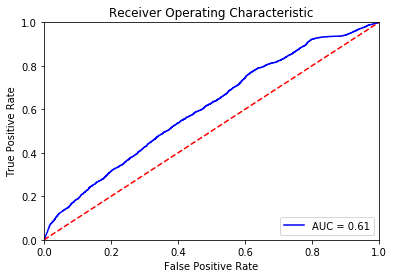

In [345]:
fpr, tpr, threshold = metrics.roc_curve(y_test, clf.predict_proba(X_test_lr)[:,1])
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [192]:
#import necessary packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [403]:
#Decision Tree

clf = DecisionTreeClassifier()

param_test = {
        'max_depth': [1,2,3,4,5,6,7,8,9,10]
    }

gsearch = GridSearchCV(clf, param_grid = param_test, scoring='roc_auc')
gsearch.fit(X_train,y_train)

print(gsearch.best_params_)
print('best score is:',str(gsearch.best_score_))

/Users/raywu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 8}
best score is: 0.9119145334732062


In [404]:
clf = DecisionTreeClassifier(max_depth=8).fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}\n'
      .format(clf.score(X_test, y_test)))

y_pred = clf.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)
print('Accuracy: %f' % metrics.accuracy_score(y_test,y_pred))
print('Recall: %f' % (metrics.recall_score(y_test,y_pred)))
print('Precision: %f' % (metrics.precision_score(y_test,y_pred)))
print('F1 Score: %f' % (metrics.f1_score(y_test,y_pred)))

Accuracy of Decision Tree classifier on training set: 0.84
Accuracy of Decision Tree classifier on test set: 0.84

[[3292  952]
 [ 525 4462]]
Accuracy: 0.839996
Recall: 0.894726
Precision: 0.824160
F1 Score: 0.857994


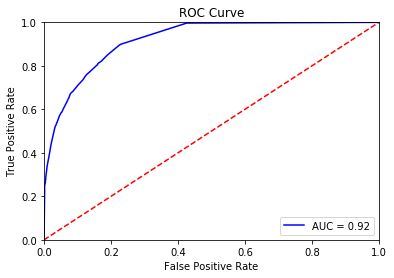

In [407]:
fpr, tpr, threshold = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [408]:
#feature importance
for i in zip(X_train.columns, clf.feature_importances_):
    print(i)

('opensperday', 0.007530139109000436)
('perc_complete', 0.005792025948668418)
('perc_rate', 0.0006315352495711269)
('seriesperopen', 0.0035152831405880084)
('vidswatchperday', 0.39376163618634885)
('seriesperday', 0.004577775682096763)
('mssgsperday', 0.22384034108649)
('perc_mssgs_comp', 0.029137991790111777)
('weighted_mssgs', 0.3312132718071246)


In [412]:
#assign churn probabilities for each user
ch_prob = clf.predict_proba(X)[:,1]
ch_pred = clf.predict(X)

In [496]:
#Determing churn/not churn based on chosen decision threshold
df_mod['probs'] = ch_prob
df_mod['pred'] = np.where(df_mod.probs>=0.67,1,0)
df_mod['promo_price'] = df_mod.discount_price * 0.7

In [712]:
#obtain various metrics after simulating 50 times
#rev_base = base revenue if no action is taken (revenue from renewed only)
#rev_base_offer = revenue from those identified as churn but would have renewed anyway
#churn_responds = number of people who were identified as churn and accepted retention offer
#churn_responds_revenue = revenue from the churn_responds subscribers
#total=rev_base + rev_base_offer + churn_responds_revenue
def proforma(threshold):
    test=[]
    df_mod['pred'] = np.where(df_mod.probs>=threshold,1,0)
    for i in range(50):
        prob_offer=[]
        for index, row in df_mod.iterrows():
            if (row['pred']==1 and row['renew']==False):
                prob_offer.append(random.random())
            else:
                prob_offer.append(-1)
    
        df_mod['yes_offer']=prob_offer
        
        rev_base=df_mod[(df_mod.renew==True) & (df_mod.pred==0)].discount_price.sum()
        rev_base_offer=df_mod[(df_mod.renew==True) & (df_mod.pred==1)].promo_price.sum()
        churn_responds=df_mod[df_mod.yes_offer>=0.7].shape[0]
        churn_responds_revenue=df_mod[df_mod.yes_offer>=0.7].promo_price.sum()
        total=rev_base+rev_base_offer+churn_responds_revenue
        test.append([rev_base,rev_base_offer,churn_responds,churn_responds_revenue,total])
    df_test=pd.DataFrame(test)
    return df_test.mean(axis=0)

In [713]:
proforma(0.9)

0    61952.792900
1     1071.915250
2     2619.080000
3     8274.497238
4    71299.205388
dtype: float64

# LTV calculation

In [542]:
pickle_in = open("subscribers","rb")
subs = pickle.load(pickle_in)
pickle_in = open("engagement","rb")
eng = pickle.load(pickle_in)
pickle_in = open("customer_service_reps","rb")
csr = pickle.load(pickle_in)
ads=pd.read_csv('adspend.csv')

In [543]:
#change adspend data layout

ads=ads.set_index('date')
ads=ads.stack().reset_index().rename(columns={'date':'months','level_1':'channel',0:'cost'})
ads['cost']=ads.cost.str.replace(",","").astype(float)

#convert dates to month for merging
ads['months']=pd.to_datetime(ads['months'])
ads['months']=ads.months.dt.month

In [546]:
#adjust June cost for only 1 day in month 
ads['cost']=np.where(ads.months==6,ads.cost/30,ads.cost)
total_cost=ads.cost.sum()

In [553]:
#proportion of subscribers in subs that came from one of the 8 channels
extrap=subs[(subs.attribution_technical.isin(ads.channel)) & (subs.retarget_TF==False)].shape[0]/subs.shape[0]

#average cost taken from csr total unique subscribers * 'expected' percentage coming from 8 channels
average_cac=total_cost/(csr.subid.nunique()*extrap)

In [557]:
#return with only subscribers with engagement data
csr=csr[csr.subid.isin(eng.subid)]

In [558]:
#get max payment period for each subscriber
df=csr.groupby('subid')['payment_period'].max().reset_index(name='max_period')
df2=pd.merge(df,csr,on=['subid'])

#get subscribers who are current subscribers and in period 1
df2=df2[(df2.max_period==1) & (df2.current_sub_TF==True)]

In [561]:
csr=csr[csr.subid.isin(df2.subid)]

#return only info from 1st period in csr
csr=csr[csr.payment_period==1]

#return only csr info for users who didn't ask for refund after trial
csr=csr[csr.subid.isin(subs[subs.refund_after_trial_TF==False].subid)]

In [571]:
#return engagement data for non-NA and users in csr and data not from trial period
eng = eng[(eng['app_opens'].notna()) & (eng.subid.isin(csr.subid)) & (eng.payment_period!=0)]

In [573]:
#create features to roll up to subscriber level
df=eng.groupby(['subid']).agg(
    days=('date','nunique'),
    appopens=('app_opens','sum'),
    vids_complete=('num_videos_completed','sum'),
    num_vids_30sec=('num_videos_more_than_30_seconds','sum'),
    num_vids_rated=('num_videos_rated','sum'),
    series_starts=('num_series_started','sum'),
    max_date=('date','max'),
    min_date=('date','min'),
    mssgs=('cust_service_mssgs','sum')
).reset_index()

df['duration']=(df.max_date-df.min_date).dt.days+1
df['daysperduration']=df.days/df.duration
df['opensperday']=df.appopens/df.days
df['perc_complete'] = df.apply(lambda x: 0 if x['num_vids_30sec']==0 else x['vids_complete']/x['num_vids_30sec'], axis=1)
df['perc_rate'] = df.apply(lambda x: 0 if x['vids_complete']==0 else x['num_vids_rated']/x['vids_complete'], axis=1)
df['seriesperopen'] = df.apply(lambda x: 0 if x['appopens']==0 else x['series_starts']/x['appopens'], axis=1)
df['vidswatchperday']=df.num_vids_30sec/df.days
df['seriesperday']=df.series_starts/df.days
df['mssgsperday']=df.mssgs/df.days
df['perc_mssgs_comp'] = df.apply(lambda x: 0 if x['vids_complete']==0 else x['mssgs']/x['vids_complete'], axis=1)
df['weighted_mssgs']=df.mssgs*df.daysperduration

In [577]:
#merge datasets
df_sd=pd.merge(subs,df,on=['subid'])
df_clv=pd.merge(df_sd,csr,on=['subid'])

In [586]:
#get dataset to input into the decision tree model
df_clvmod=df_clv[['opensperday', 'perc_complete', 'perc_rate',
       'seriesperopen', 'vidswatchperday', 'seriesperday', 'mssgsperday',
       'perc_mssgs_comp', 'weighted_mssgs']]

In [589]:
#assign churn probability to each subscriber
clv_prob=clf.predict_proba(df_clvmod)[:,1]
df_clv['prob_churn']=clv_prob

In [607]:
#calculate CLV

disc_rate=((1+0.1)**(1/3))-1
df_clv['clv']=(df_clv.discount_price*4)*((1+disc_rate)/(1+disc_rate-(1-df_clv.prob_churn)))-average_cac

(array([6.332e+03, 4.087e+03, 1.253e+03, 1.036e+03, 1.292e+03, 1.019e+03,
        6.370e+02, 1.271e+03, 0.000e+00, 2.700e+01, 0.000e+00, 0.000e+00,
        4.600e+01, 2.000e+00, 2.385e+03]),
 array([15., 17., 19., 21., 23., 25., 27., 29., 31., 33., 35., 37., 39.,
        41., 43., 45.]),
 <a list of 15 Patch objects>)

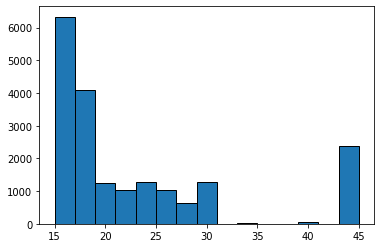

In [621]:
#plot distribution of CLV
plt.hist(df_clv.clv,bins=np.linspace(15,45,16),ec='black')